In [9]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import urllib.request as req

In [10]:
def gpx_parser(file):
    root = ET.parse(file).getroot()
    
    # root[0].tag is 'metadata', root[0][0].tag is 'name'
    trk_name = root[0][0].text
    
    # root[-1].tag is 'trk', root[-1][0].tag is 'name'
    assert trk_name == root[-1][0].text
        
    trk_wpts = {}
    for x in root[1:-1]:
        # x.tag is 'wpt'
        wpt_lat = x.attrib['lat'] # :haslat
        wpt_lon = x.attrib['lon'] # :haslon
        # x[0].tag is 'ele'
        wpt_ele = x[0].text # :hasele       
        # x[1].tag is 'time'
        wpt_time = x[1].text # :hastime
        # x[2].tag is 'name'
        wpt_name = x[2].text # :hasname
        
        wpt = 'wpt' + wpt_ele
        trk_wpts[wpt] = {'lat': wpt_lat, 'lon': wpt_lon, 'ele': wpt_ele, 'time': wpt_time, 'name': wpt_name}
        
        
    trk_trkpts = {}
    # root[-1].tag is 'trk', root[-1][1].tag is 'trkseg'
    for x in root[-1][1][:]:
        # x.tag is 'trkpt'
        trkpt_lat = x.attrib['lat'] # :haslat
        trkpt_lon = x.attrib['lon'] # :haslon
        # x[0].tag is 'ele'
        trkpt_ele = x[0].text # :hasele       
        # x[1].tag is 'time'
        trkpt_time = x[1].text # :hastime
        
        trkpt = 'trkpt' + trkpt_ele
        trk_trkpts[trkpt] = {'lat': trkpt_lat, 'lon': trkpt_lon, 'ele': trkpt_ele, 'time': trkpt_time}
        
    return trk_name, trk_wpts, trk_trkpts

In [11]:
#gpx_parser('./GPX_Tracks/4sDDFdd4cjA.gpx')

In [12]:
def link2osm(gpx_file):    
    trk_name, trk_wpts, trk_trkpts = gpx_parser(gpx_file)
    
    wpt_lats = [float(trk_wpts[wpt]['lat']) for wpt in trk_wpts]
    wpt_minlat, wpt_maxlat = min(wpt_lats), max(wpt_lats)
    wpt_lons = [float(trk_wpts[wpt]['lon']) for wpt in trk_wpts]
    wpt_minlon, wpt_maxlon = min(wpt_lons), max(wpt_lons)
    
    trkpt_lats = [float(trk_trkpts[trkpt]['lat']) for trkpt in trk_trkpts]
    trkpt_minlat, trkpt_maxlat = min(trkpt_lats), max(trkpt_lats)
    trkpt_lons = [float(trk_trkpts[trkpt]['lon']) for trkpt in trk_trkpts]
    trkpt_minlon, trkpt_maxlon = min(trkpt_lons), max(trkpt_lons)
    
    #print('wpt min: ', wpt_minlat, wpt_minlon)
    #print('wpt max: ', wpt_maxlat, wpt_maxlon)
    
    #print('trkpt min: ', trkpt_minlat, trkpt_minlon)
    #print('trkpt max: ', trkpt_maxlat, trkpt_maxlon)
    
    # the naive surroundings
    minlat = trkpt_minlat - 0.005
    minlon = trkpt_minlon - 0.005
    maxlat = trkpt_maxlat + 0.005
    maxlon = trkpt_maxlon + 0.005
    
    osm_bounds = (minlat, minlon, maxlat, maxlon)
    print('osm bounds: ', osm_bounds)
    
    bound_lats = [minlat, maxlat, maxlat, minlat, minlat]
    bound_lons = [minlon, minlon, maxlon, maxlon, minlon]
    
    data = ((wpt_lats, wpt_lons), (trkpt_lats, trkpt_lons), (bound_lats, bound_lons))
    colors = ('red', 'blue', 'black')
    groups = ('wpt', 'trkpt', 'bounds')
    
    
    for data, color, group in zip(data, colors, groups):
        x, y = data
    
        plt.plot(x, y, '-ok', c  = color, label = group)
        plt.title('gpx track: %s'%(trk_name))
        plt.xlabel('lat')
        plt.ylabel('lon')
        plt.grid(True)
        plt.legend()
   
    #plt.show()
    #plt.clf()
    
    bbox = '%f,%f,%f,%f'%(minlon, minlat, maxlon, maxlat)
    osm_file = '%s.osm'%(trk_name)
    
    req.urlretrieve('https://api.openstreetmap.org/api/0.6/map?bbox=%s'%(bbox), osm_file)
  
    print('%s downloaded'%(osm_file))
    
    return osm_file

In [13]:
#link2osm('./GPX_Tracks/4sDDFdd4cjA.gpx')

In [14]:
def osm_parser(file):
    root = ET.parse(file).getroot()
    
    # root[0].tag is 'bounds'
    assert root[0].tag == 'bounds'
    osm_bounds = (root[0].attrib['minlat'], root[0].attrib['minlon'], root[0].attrib['maxlat'], root[0].attrib['maxlon'])
    
    osm_nds = {}
    for x in root.findall('node'):
        # x.tag is 'node'
        nd_id = x.attrib['id'] # hasid
        nd = 'nd' + nd_id
        
        nd_ts = x.attrib['timestamp'] # hasts
        nd_lat = x.attrib['lat'] # haslat 
        nd_lon = x.attrib['lon'] # haslon
        # more objects can be added...
        nd_name = 'none' # hasname
        nd_isinterested = 'no' # isinterested
        
        nd_tourism = 'none' # tourism   
        nd_amenity = 'none' # amenity
        nd_leisure = 'none' # leisure
        
        nd_website = 'none' # website
        nd_wikidata = 'none' # wikidata
        nd_wikipedia = 'none' # wikipedia
        
        nd_ways = [] # ontheway
        nd_rlts = [] # intherlt
        
        for tag in x.findall('tag'):
            tag_k, tag_v = tag.attrib['k'], tag.attrib['v']
            
            if tag_k == 'name':
                nd_name = tag_v
            
            # definition of 'isinterested' is to be discussed...
            # https://wiki.openstreetmap.org/wiki/Map_Features
            # isinterestedtags = ['tourism', 'amenity', 'leisure']
            # if tag_k in isinterestedtags:
            if (tag_k == 'tourism' or tag_k == 'amenity' or tag_k == 'leisure'):
                nd_isinterested = 'yes'
            else:
                break
            
            # if isinterested:
            if tag_k == 'tourism':
                nd_tourism = tag_v
            if tag_k == 'amenity':
                nd_amenity = tag_v
            if tag_k == 'leisure':
                nd_leisure = tag_v
            if tag_k == 'website':
                nd_website = tag_v
            if tag_k == 'wikidata':
                nd_wikidata = tag_v
            if tag_k == 'wikipedia':
                nd_wikipedia = tag_v
                
        osm_nds[nd] = {'id': nd_id, 'ts': nd_ts, 'lat': nd_lat, 'lon': nd_lon, 'name': nd_name, 'isinterested': nd_isinterested, 
                       'tourism': nd_tourism, 'amenity': nd_amenity, 'leisure': nd_leisure, 
                       'website': nd_website, 'wikidata': nd_wikidata, 'wikipedia': nd_wikipedia,
                       'ways': nd_ways, 'rlts': nd_rlts}
    
    osm_ways = {} 
    for x in root.findall('way'):
        # x.tag is 'way'
        way_id = x.attrib['id'] # hasid
        way = 'way' + way_id
        
        way_nds = [] # hasnd
        # more objects can be added...
        way_name = 'none' # hasname
        way_isinterested = 'no' # isinterested
        
        way_tourism = 'none' # tourism   
        way_amenity = 'none' # amenity
        way_leisure = 'none' # leisure
        
        way_website = 'none' # website
        way_wikidata = 'none' # wikidata
        way_wikipedia = 'none' # wikipedia
        
        way_rlts = [] # intherlt
        
        for nd in x.findall('nd'):
            nd_ref = nd.attrib['ref']
            nd = 'nd' + nd_ref
            way_nds.append(nd)
            
            osm_nds[nd]['ways'].append(way)
        
        for tag in x.findall('tag'):
            tag_k, tag_v = tag.attrib['k'], tag.attrib['v']
            
            if tag_k == 'name':
                nd_name = tag_v
            
            # definition of 'isinterested' is to be discussed...
            # isinterestedtags = ['tourism', 'amenity', 'leisure']
            # if tag_k in isinterestedtags:
            if (tag_k == 'amenity' or tag_k == 'tourism' or tag_k == 'leisure'):
                way_isinterested = 'yes'
            else:
                break
            
            # if isinterested:
            if tag_k == 'tourism':
                way_tourism = tag_v
            if tag_k == 'amenity':
                way_amenity = tag_v
            if tag_k == 'leisure':
                way_leisure = tag_v
            if tag_k == 'website':
                way_website = tag_v
            if tag_k == 'wikidata':
                way_wikidata = tag_v
            if tag_k == 'wikipedia':
                way_wikipedia = tag_v

        osm_ways[way] = {'id': way_id, 'nds': way_nds, 'name': way_name, 'isinterested': way_isinterested, 
                         'tourism': way_tourism, 'amenity': way_amenity, 'leisure': way_leisure, 
                         'website': way_website, 'wikidata': way_wikidata, 'wikipedia': way_wikipedia,
                         'rlts': way_rlts}       
    
    # if the node is on the way that is interested,
    # then the node is interested
    for nd in osm_nds:
        for way in osm_nds[nd]['ways']:
            if (way in osm_ways) and (osm_ways[way]['isinterested'] == 'yes'):
                osm_nds[nd]['isinterested'] = 'yes'
    
    osm_rlts = {}
    for x in root.findall('relation'):
        # x.tag is 'relation'
        rlt_id = x.attrib['id'] # hasid
        rlt = 'rlt' + rlt_id
        rlt_ways = [] # hasway
        rlt_nds = [] # hasnd
        rlt_rlts = [] # intherlt
        # more objects can be added...
        rlt_name = 'none' # hasname
        rlt_isinterested = 'no' # isinterested
        
        rlt_ishikingroute = 'no' # ishikingroute
        
        rlt_website = 'none' # website
        rlt_wikidata = 'none' # wikidata
        rlt_wikipedia = 'none' # wikipedia
        
        for member in x.findall('member'):
            mtype = member.attrib['type']
            
            if mtype == 'way':
                way_ref = member.attrib['ref']
                way = 'way' + way_ref
                rlt_ways.append(way)
                # the key, way, may be beyond the area
                if way in osm_ways:
                    osm_ways[way]['rlts'].append(rlt)
                
            if mtype == 'node':
                nd_ref = member.attrib['ref']
                nd = 'nd' + nd_ref
                rlt_nds.append(nd)
                # the key, nd, may be beyond the area
                if nd in osm_nds:
                    osm_nds[nd]['rlts'].append(rlt)
                
            if mtype == 'relation':
                rlt_ref = member.attrib['ref']
                rlt = 'rlt' + rlt_ref
                rlt_rlts.append(rlt)
                
        for tag in x.findall('tag'):
            tag_k, tag_v = tag.attrib['k'], tag.attrib['v']
            
            if tag_k == 'name':
                rlt_name = tag_v
                
            if tag_k == 'route' and tag_v == 'hiking':
                rlt_isinterested = 'yes'
                rlt_ishikingroute= 'yes'
            else:
                break
            
            if tag_k == 'website':
                rlt_website = tag_v
            if tag_k == 'wikidata':
                rlt_wikidata = tag_v
            if tag_k == 'wikipedia':
                rlt_wikipedia = tag_v
              
        osm_rlts[rlt] = {'id': rlt_id, 'ways': rlt_ways, 'nds': rlt_nds, 'rlts': rlt_rlts, 'name': rlt_name,
                         'isinterested': rlt_isinterested, 'ishikingroute': rlt_ishikingroute,
                         'website': rlt_website, 'wikidata': rlt_wikidata, 'wikipedia': rlt_wikipedia}
    
    # if the node is in the relation that is interested,
    # then the node is interested
    for nd in osm_nds:
        for rlt in osm_nds[nd]['rlts']:
            if (rlt in osm_rlts) and (osm_rlts[rlt]['isinterested'] == 'yes'):
                osm_nds[nd]['isinterested'] = 'yes'
    
    return osm_bounds, osm_nds, osm_ways, osm_rlts

In [15]:
#osm_file = link2osm('./GPX_Tracks/4sDDFdd4cjA.gpx')
#osm_parser(osm_file)

In [16]:
def analyzer(gpx_file, nway = 9):
    
    osm_file = link2osm(gpx_file)    
    osm_bounds, osm_nds, osm_ways = osm_parser(osm_file)[:-1]

    print('osm bounds:', osm_bounds)
     
    nd_lats = [float(osm_nds[nd]['lat']) for nd in osm_nds]
    nd_lons = [float(osm_nds[nd]['lon']) for nd in osm_nds]
    
    data = [(nd_lats, nd_lons)]
    colors = ['green']
    groups = ['nd']
    
    print('there are %d ways.'%len(osm_ways))
    
    way_lats, way_lons = {}, {}
    for way in osm_ways:
        way_nds = osm_ways[way]['nds']
        way_lats[way] = [float(osm_nds[nd]['lat']) for nd in way_nds]
        way_lons[way] = [float(osm_nds[nd]['lon']) for nd in way_nds]
        data.append((way_lats[way], way_lons[way]))
        colors.append('red')
        groups.append(way)
    
    way_counter = 0
    for data, color, group in zip(data, colors, groups):
        if way_counter > nway:
            break
        x, y = data
    
        plt.scatter(x, y, c  = color, label = group)
        plt.title(osm_file)
        plt.xlabel('lat')
        plt.ylabel('lon')
        plt.grid(True)
        if group == 'nd':
            plt.legend()
        #plt.show()
        
        way_counter += 1
   
    plt.show()   

In [17]:
analyzer('./GPX_Tracks/4sDDFdd4cjA.gpx', 29)

FileNotFoundError: [Errno 2] No such file or directory: './GPX_Tracks/4sDDFdd4cjA.gpx'

In [18]:
def around(lat, lon, osm_nds, osm_ways, osm_rlts, radius = 0.005):
    
    lat, lon = float(lat), float(lon)
    # naive surrounding, adjusted by radius
    minlat, maxlat = (lat - radius), (lat + radius)
    minlon, maxlon = (lon - radius), (lon + radius)
    
    surround = {'nds': [], 'ways': [], 'rlts': []}
    for nd in osm_nds:
        nd_lat, nd_lon = float(osm_nds[nd]['lat']), float(osm_nds[nd]['lon'])
        if (nd_lat >= minlat and nd_lat <= maxlat) and (nd_lon >= minlon and nd_lon <= maxlon):
            # we only care about the surrounded nodes that is interested
            if osm_nds[nd]['isinterested'] == 'yes':
                surround['nds'].append(nd)
            
            # the ways that include the node are interested
            for way in osm_nds[nd]['ways']:
                if (way in osm_ways) and (osm_ways[way]['isinterested'] == 'yes'):
                    surround['ways'].append(way)
            
            # the relations that include the node are interested
            for rlt in osm_nds[nd]['rlts']:
                if (rlt in osm_rlts) and (osm_rlts[rlt]['isinterested'] == 'yes'):
                    surround['nds'].append(nd)
    
    return surround

In [19]:
def gen_rdf(gpx_file):
    
    trk_name, trk_wpts, trk_trkpts = gpx_parser(gpx_file)  
    osm_file = link2osm(gpx_file)
    osm_bounds, osm_nds, osm_ways, osm_rlts = osm_parser(osm_file)
    
    trk_surroundingnds = [] # hassurroundingnds
    trk_surroundingways = [] # hassurroundingways
    trk_surroundingrlts = [] # hassurroundingrlts
    
    for trkpt in trk_trkpts:
        trkpt_lat, trkpt_lon = trk_trkpts[trkpt]['lat'], trk_trkpts[trkpt]['lon']
     
        trkpt_surround = around(trkpt_lat, trkpt_lon, osm_nds, osm_ways, osm_rlts)
        trk_trkpts[trkpt]['surroundingnds'] = trkpt_surround['nds']
        trk_trkpts[trkpt]['surroundingways'] = trkpt_surround['ways']
        trk_trkpts[trkpt]['surroundingrlts'] = trkpt_surround['rlts']
    
        trk_surroundingnds += trk_trkpts[trkpt]['surroundingnds']
        trk_surroundingways += trk_trkpts[trkpt]['surroundingways']
        trk_surroundingrlts += trk_trkpts[trkpt]['surroundingrlts']
    
    trk_surroundingnds = list(set(trk_surroundingnds))
    trk_surroundingways = list(set(trk_surroundingways)) 
    trk_surroundingrlts = list(set(trk_surroundingrlts))

    
    with open('%s.ttl'%(trk_name), 'w') as f:
        f.write('@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n')
        f.write('@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .\n')
        f.write('@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n')
        f.write('\n')
        f.write('@prefix : <http://www.topografix.com/GPX/1/1> .\n')
        f.write('@prefix osm: <https://www.openstreetmap.org/export> .\n')
        f.write('@prefix dbpedia: <http://dbpedia.org/ontology/> .\n')
        f.write('@prefix wikidata: <https://www.wikidata.org/wiki/> .\n')
        f.write('@prefix wikipedia: <https://en.wikipedia.org/wiki/> .\n')
        f.write('\n')
          
        
        f.write(':trk%s a :GPXtrack .\n'%(''.join(trk_name.split())))
        f.write('\n')
        
        f.write(':trk%s :hasname "%s"^^xsd:string .\n'%(''.join(trk_name.split()), trk_name))
        f.write('\n')
        
        ltrk_wpts = ':trk%s :haswpt '%(''.join(trk_name.split()))
        for wpt in trk_wpts:
            ltrk_wpts += ':%s, '%(wpt)
        ltrk_wpts = ltrk_wpts[:-2] + ' .\n'
        f.write(ltrk_wpts)
        f.write('\n')
        
        ltrk_trkpts = ':trk%s :hastrkpt '%(''.join(trk_name.split()))
        for trkpt in trk_trkpts:
            ltrk_trkpts += ':%s, '%(trkpt)
        ltrk_trkpts = ltrk_trkpts[:-2] + ' .\n'
        f.write(ltrk_trkpts)
        f.write('\n')
        
        ltrk_surroundingnds = ':trk%s :hassurroundingnds '%(''.join(trk_name.split()))
        if trk_surroundingnds:
            for nd in trk_surroundingnds:
                ltrk_surroundingnds += 'osm:%s, '%(nd)
            ltrk_surroundingnds = ltrk_surroundingnds[:-2] + ' .\n'
        else:
            ltrk_surroundingnds += 'osm:none .\n'
        f.write(ltrk_surroundingnds)
        f.write('\n')
        
        ltrk_surroundingways = ':trk%s :hassurroundingways '%(''.join(trk_name.split()))
        if trk_surroundingways:
            for way in trk_surroundingways:
                ltrk_surroundingways += 'osm:%s, '%(way)
            ltrk_surroundingways = ltrk_surroundingways[:-2] + ' .\n'
        else:
            ltrk_surroundingways += 'osm:none .\n'
        f.write(ltrk_surroundingways)
        f.write('\n')
        
        ltrk_surroundingrlts = ':trk%s :hassurroundingrlts '%(''.join(trk_name.split()))
        if trk_surroundingrlts:
            for rlt in trk_surroundingrlts:
                ltrk_surroundingrlts += 'osm:%s, '%(rlt)
            ltrk_surroundingrlts = ltrk_surroundingrlts[:-2] + ' .\n'
        else:
            ltrk_surroundingrlts += 'osm:none .\n'
        f.write(ltrk_surroundingrlts)
        f.write('\n')
        
        for wpt in trk_wpts:
            f.write(':%s :haslat "%s"^^xsd:float ;\n'%(wpt, trk_wpts[wpt]['lat']))
            f.write(' ' * (len(wpt) + 2) + ':haslon "%s"^^xsd:float ;\n'%(trk_wpts[wpt]['lon']))
            f.write(' ' * (len(wpt) + 2) + ':hasele "%s"^^xsd:integer ;\n'%(trk_wpts[wpt]['ele']))
            f.write(' ' * (len(wpt) + 2) + ':hastime "%s"^^xsd:dateTime ;\n'%(trk_wpts[wpt]['time']))
            f.write(' ' * (len(wpt) + 2) + ':hasname "%s"^^xsd:string .\n'%(trk_wpts[wpt]['name']))
            f.write('\n')
        
        for trkpt in trk_trkpts:
            f.write(':%s :haslat "%s"^^xsd:float ;\n'%(trkpt, trk_trkpts[trkpt]['lat']))
            f.write(' ' * (len(trkpt) + 2) + ':haslon "%s"^^xsd:float ;\n'%(trk_trkpts[trkpt]['lon']))
            f.write(' ' * (len(trkpt) + 2) + ':hasele "%s"^^xsd:integer ;\n'%(trk_trkpts[trkpt]['ele']))
            f.write(' ' * (len(trkpt) + 2) + ':hastime "%s"^^xsd:dateTime ;\n'%(trk_trkpts[trkpt]['time']))
            
            ltrk_trkpts_surroundingnds = ' ' * (len(trkpt) + 2) + ':hassurroundingnds '
            if trk_trkpts[trkpt]['surroundingnds']:
                for nd in trk_trkpts[trkpt]['surroundingnds']:
                    ltrk_trkpts_surroundingnds += 'osm:%s, '%(nd)
                ltrk_trkpts_surroundingnds = ltrk_trkpts_surroundingnds[:-2] + ' ;\n'
            else:
                ltrk_trkpts_surroundingnds += 'osm:none ;\n'
            f.write(ltrk_trkpts_surroundingnds)
                    
            ltrk_trkpts_surroundingways = ' ' * (len(trkpt) + 2) + ':hassurroundingways '
            if trk_trkpts[trkpt]['surroundingways']:
                for nd in trk_trkpts[trkpt]['surroundingways']:
                    ltrk_trkpts_surroundingways += 'osm:%s, '%(nd)
                ltrk_trkpts_surroundingways = ltrk_trkpts_surroundingways[:-2] + ' ;\n'
            else:
                ltrk_trkpts_surroundingways += 'osm:none ;\n'
            f.write(ltrk_trkpts_surroundingways)
                    
            ltrk_trkpts_surroundingrlts = ' ' * (len(trkpt) + 2) + ':hassurroundingrlts '
            if trk_trkpts[trkpt]['surroundingrlts']:
                for nd in trk_trkpts[trkpt]['surroundingrlts']:
                    ltrk_trkpts_surroundingrlts += 'osm:%s, '%(nd)
                ltrk_trkpts_surroundingrlts = ltrk_trkpts_surroundingrlts[:-2] + ' .\n'
            else:
                ltrk_trkpts_surroundingrlts += 'osm:none .\n'
            f.write(ltrk_trkpts_surroundingrlts)
                    
            f.write('\n')
                 
        for nd in trk_surroundingnds:
            f.write('osm:%s osm:haslat "%s"^^xsd:float ;\n'%(nd, osm_nds[nd]['lat']))
            f.write(' ' * (len(nd) + 5) + 'osm:haslon "%s"^^xsd:float ;\n'%(osm_nds[nd]['lon']))
            f.write(' ' * (len(nd) + 5) + 'osm:hasid "%s"^^xsd:number ;\n'%(osm_nds[nd]['id']))
            f.write(' ' * (len(nd) + 5) + 'osm:hasts "%s"^^xsd:dateTime ;\n'%(osm_nds[nd]['ts']))
            f.write(' ' * (len(nd) + 5) + 'osm:hasname "%s"^^xsd:string ;\n'%(osm_nds[nd]['name']))
            f.write(' ' * (len(nd) + 5) + 'osm:isinterested osm:%s ;\n'%(osm_nds[nd]['isinterested']))
            
            f.write(' ' * (len(nd) + 5) + 'osm:tourism dbpedia:%s ;\n'%(osm_nds[nd]['tourism']))
            f.write(' ' * (len(nd) + 5) + 'osm:amenity dbpedia:%s ;\n'%(osm_nds[nd]['amenity']))
            f.write(' ' * (len(nd) + 5) + 'osm:leisure dbpedia:%s ;\n'%(osm_nds[nd]['leisure']))
            f.write(' ' * (len(nd) + 5) + 'osm:website "%s"^^xsd:string ;\n'%(osm_nds[nd]['website']))
            f.write(' ' * (len(nd) + 5) + 'osm:wikidata wikidata:%s ;\n'%(osm_nds[nd]['wikidata']))
            f.write(' ' * (len(nd) + 5) + 'osm:wikipedia wikipedia:%s ;\n'%(osm_nds[nd]['wikipedia']))
                    
            ltrk_surround_way = ' ' * (len(nd) + 5) + 'osm:ontheway '
            if osm_nds[nd]['ways']:
                for way in osm_nds[nd]['ways']:
                    ltrk_surround_way += 'osm:%s, '%(way)
                ltrk_surround_way = ltrk_surround_way[:-2] + ' ;\n'
            else:
                ltrk_surround_way += 'osm:none ;\n'
            f.write(ltrk_surround_way)
            
            ltrk_surround_rlt = ' ' * (len(nd) + 5) + 'osm:intherlt '
            if osm_nds[nd]['rlts']:
                for rlt in osm_nds[nd]['rlts']:
                    ltrk_surround_rlt += 'osm:%s, '%(rlt)
                ltrk_surround_rlt = ltrk_surround_rlt[:-2] + ' .\n'
            else:
                ltrk_surround_rlt += 'osm:none .\n'
            f.write(ltrk_surround_rlt)
            
            f.write('\n')
            
        for way in trk_surroundingways:
            f.write('osm:%s osm:hasid "%s"^^xsd:number ;\n'%(way, osm_ways[way]['id']))
            f.write(' ' * (len(way) + 5) + 'osm:hasname "%s"^^xsd:string ;\n'%(osm_ways[way]['name']))
            f.write(' ' * (len(way) + 5) + 'osm:isinterested osm:%s ;\n'%(osm_ways[way]['isinterested']))
            
            f.write(' ' * (len(way) + 5) + 'osm:tourism dbpedia:%s ;\n'%(osm_ways[way]['tourism']))
            f.write(' ' * (len(way) + 5) + 'osm:amenity dbpedia:%s ;\n'%(osm_ways[way]['amenity']))
            f.write(' ' * (len(way) + 5) + 'osm:leisure dbpedia:%s ;\n'%(osm_ways[way]['leisure']))
            f.write(' ' * (len(way) + 5) + 'osm:website "%s"^^xsd:string ;\n'%(osm_ways[way]['website']))
            f.write(' ' * (len(way) + 5) + 'osm:wikidata wikidata:%s ;\n'%(osm_ways[way]['wikidata']))
            f.write(' ' * (len(way) + 5) + 'osm:wikipedia wikipedia:%s ;\n'%(osm_ways[way]['wikipedia']))        
                    
            ltrk_surround_way_nd = ' ' * (len(way) + 5) + 'osm:hasnd '
            if osm_ways[way]['nds']:
                for nd in osm_ways[way]['nds']:
                    ltrk_surround_way_nd += 'osm:%s, '%(nd)
                ltrk_surround_way_nd = ltrk_surround_way_nd[:-2] + ' ;\n'
            else:
                ltrk_surround_way_nd += 'osm:none ;\n'
            f.write(ltrk_surround_way_nd)
            
            ltrk_surround_way_rlt = ' ' * (len(way) + 5) + 'osm:intherlt '
            if osm_ways[way]['rlts']:
                for rlt in osm_ways[way]['rlts']:
                    ltrk_surround_way_rlt += 'osm:%s, '%(rlt)
                ltrk_surround_way_rlt = ltrk_surround_way_rlt[:-2] + ' .\n'
            else:
                ltrk_surround_way_rlt += 'osm:none .\n'
            f.write(ltrk_surround_way_rlt)
            
            f.write('\n')
    
        for rlt in trk_surroundingrlts:
            f.write('osm:%s osm:hasid "%s"^^xsd:number ;\n'%(rlt, osm_rlts[rlt]['id']))
            f.write(' ' * (len(rlt) + 5) + 'osm:hasname "%s"^^xsd:string ;\n'%(osm_rlts[rlt]['name']))
            f.write(' ' * (len(rlt) + 5) + 'osm:isinterested osm:%s ;\n'%(osm_rlts[rlt]['isinterested']))
            
            f.write(' ' * (len(rlt) + 5) + 'osm:ishikingroute osm:%s ;\n'%(osm_rlts[rlt]['ishikingroute']))        
            f.write(' ' * (len(rlt) + 5) + 'osm:website "%s"^^xsd:string ;\n'%(osm_rlts[rlt]['website']))
            f.write(' ' * (len(rlt) + 5) + 'osm:wikidata wikidata:%s ;\n'%(osm_rlts[rlt]['wikidata']))
            f.write(' ' * (len(rlt) + 5) + 'osm:wikipedia wikipedia:%s ;\n'%(osm_rlts[rlt]['wikipedia']))         
                    
            ltrk_surround_rlt_nd = ' ' * (len(rlt) + 5) + 'osm:hasnd '
            if osm_rlts[rlt]['nds']:
                for nd in osm_rlts[rlt]['nds']:
                    ltrk_surround_rlt_nd += 'osm:%s, '%(nd)
                ltrk_surround_rlt_nd = ltrk_surround_rlt_nd[:-2] + ' ;\n'
            else:
                ltrk_surround_rlt_nd += 'osm:none ;\n'
            f.write(ltrk_surround_rlt_nd)
            
            ltrk_surround_rlt_way = ' ' * (len(rlt) + 5) + 'osm:hasway '
            if osm_rlts[rlt]['ways']:
                for way in osm_rlts[rlt]['ways']:
                    ltrk_surround_rlt_way += 'osm:%s, '%(way)
                ltrk_surround_rlt_way = ltrk_surround_rlt_way[:-2] + ' ;\n'
            else:
                ltrk_surround_rlt_way += 'osm:none ;\n'
            f.write(ltrk_surround_rlt_way)        
     
            ltrk_surround_rlt_rlt = ' ' * (len(rlt) + 5) + 'osm:intherlt '
            if osm_rlts[rlt]['rlts']:
                for rlt in osm_rlts[rlt]['rlts']:
                    ltrk_surround_rlt_rlt += 'osm:%s, '%(rlt)
                ltrk_surround_rlt_rlt = ltrk_surround_rlt_rlt[:-2] + ' .\n'
            else:
                ltrk_surround_rlt_rlt += 'osm:none .\n'
            f.write(ltrk_surround_rlt_rlt)
            
            f.write('\n')
    
    

In [20]:
#gen_rdf('./GPX_Tracks/4sDDFdd4cjA.gpx')

osm bounds:  (45.783124, 6.926023, 45.813638000000005, 6.990976)
Refuge Maison Vieille - Refuge Bertone.osm downloaded
osm bounds:  (45.792068, 6.38242, 45.814523, 6.42994)
Le Mont Charvin en boucle.osm downloaded
osm bounds:  (45.975159, 6.42542, 46.004655, 6.473717)
Le tour du pic du Jalouvre.osm downloaded
osm bounds:  (46.020861999999994, 6.616539, 46.083739, 6.668864)
La Croix des 7 frères depuis Agy.osm downloaded
osm bounds:  (45.816641999999995, 6.257702, 45.837557000000004, 6.29152)
La Tournette.osm downloaded
osm bounds:  (46.184796, 6.33179, 46.239077, 6.363282)
Balcon du Léman par le Signal des Voirons.osm downloaded
osm bounds:  (46.123334, 6.567387, 46.144094, 6.601044)
Pic de Marcelly.osm downloaded
osm bounds:  (46.093716, 6.433214, 46.11535, 6.4625509999999995)
Le Môle.osm downloaded


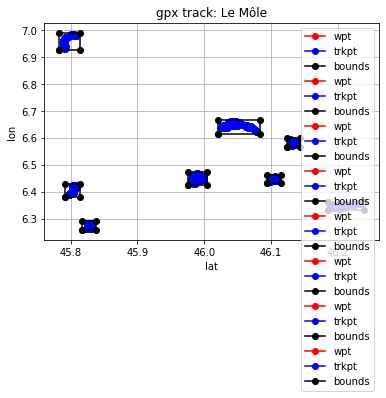

In [22]:
import os
directory = './GPX_Tracks/GPX_Tracks/'

for file in os.listdir(directory):
    gen_rdf(directory + file)